https://discourse.pymc.io/t/custom-theano-op-to-do-numerical-integration/734/

In [26]:
import theano
import theano.tensor as tt
import numpy as np
from scipy.integrate import quad
theano.config.compute_test_value = 'off'

class Integrate(theano.Op):
    def __init__(self, expr, var, *extra_vars):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = extra_vars
        self._func = theano.function(
            [var] + list(extra_vars),
            self._expr,
            on_unused_input='ignore')
    
    def make_node(self, start, stop, *extra_vars):
        self._extra_vars_node = extra_vars
        assert len(self._extra_vars) == len(extra_vars)
        self._start = start
        self._stop = stop
        vars = [start, stop] + list(extra_vars)
        return theano.Apply(self, vars, [tt.dscalar().type()])
    
    def perform(self, node, inputs, out):
        start, stop, *args = inputs
        val = quad(self._func, start, stop, args=tuple(args))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        start, stop, *args = inputs
        out, = grads
        replace = dict(zip(self._extra_vars, args))
        
        replace_ = replace.copy()
        replace_[self._var] = start
        dstart = out * theano.clone(-self._expr, replace=replace_)
        
        replace_ = replace.copy()
        replace_[self._var] = stop
        dstop = out * theano.clone(self._expr, replace=replace_)

        grads = tt.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, *self._extra_vars)
            darg = out * integrate(start, stop, *args)
            dargs.append(darg)
            
        return [dstart, dstop] + dargs

    
## Basic usage

# We define the function we want to integrate
x = tt.dscalar('x')
x.tag.test_value = np.zeros(())
a = tt.dscalar('a')
a.tag.test_value = np.ones(())

func = a ** 2 * x**2
integrate = Integrate(func, x, a)

In [27]:
# Check gradients
from theano.tests.unittest_tools import verify_grad
verify_grad(integrate, (np.array(0.), np.array(1.), np.array(2.)))
verify_grad(integrate, (np.array(-2.), np.array(5.), np.array(8.)))

In [28]:
# Now, we define values for the integral
start = tt.dscalar('start')
start.tag.test_value = np.zeros(())
stop = tt.dscalar('stop')
stop.tag.test_value = np.ones(())
a_ = tt.dscalar('a_')
a_.tag.test_value = np.ones(())

# Note, that a_ != a
val = integrate(start, stop, a_)

# Evaluate the integral and derivatives
val.eval({start: 0., stop: 1., a_: 2.})

array(1.33333333)

In [29]:
tt.grad(val, a_).eval({start: -2, stop: 1, a_: 2.})

array(12.)

In [30]:
tt.grad(val, start).eval({start: 1., stop: 2., a_: 2.})

array(-4.)

In [31]:
import pymc3 as pm

## Usage in PyMC3
with pm.Model() as model:
    start = pm.Normal('start', -5, 1)
    stop = pm.Normal('stop', 5, 1)
    a = pm.Normal('a', 0.5, 1)
    
    # Define the function to integrate in plain theano
    x = tt.dscalar('x_')
    x.tag.test_value = np.zeros(())
    a_ = tt.dscalar('a_')
    a_.tag.test_value = np.ones(())

    func = a_ ** 2 * x**2
    integrate = Integrate(func, x, a_)

    # Now we plug in the values from the model.
    # The `a_` from above corresponds to the `a` here.
    val = integrate(start, stop, a)
    pm.Normal('y', mu=val, sd=1, observed=10)
    mtrace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, stop, start]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:18<00:00, 106.70draws/s]
The acceptance probability does not match the target. It is 0.8846662882200182, but should be close to 0.8. Try to increase the number of tuning steps.


In [32]:
data_ = np.asarray([[ 2.700e+00,  2.700e+00,  2.800e+00,  3.100e+00,  3.300e+00,
         3.500e+00,  3.700e+00,  3.800e+00,  3.900e+00,  3.900e+00,
         4.500e+00,  4.600e+00,  4.900e+00,  5.100e+00,  5.200e+00,
         5.900e+00,  6.000e+00,  6.200e+00,  6.400e+00,  6.700e+00,
         7.000e+00,  7.100e+00,  7.400e+00,  7.400e+00,  7.500e+00,
         7.500e+00,  8.400e+00,  9.200e+00,  9.400e+00,  9.600e+00,
         1.020e+01,  1.040e+01,  1.040e+01,  1.200e+01,  1.200e+01,
         1.280e+01,  1.440e+01,  1.470e+01,  1.580e+01,  1.630e+01,
         1.660e+01,  1.790e+01,  1.840e+01,  1.860e+01,  1.880e+01,
         2.120e+01,  2.140e+01,  2.140e+01,  2.530e+01,  2.590e+01,
         2.690e+01,  2.940e+01,  2.980e+01,  3.450e+01,  3.500e+01,
         3.840e+01,  3.850e+01,  4.100e+01,  9.570e+01],
       [ 1.090e+02,  8.000e+00,  0.000e+00, -2.000e-01,  2.000e+01,
         2.080e+02, -9.000e-01,  6.000e+01, -1.810e+02,  0.000e+00,
        -2.100e+01, -5.300e+01,  1.720e+02, -4.000e+01, -1.900e+01,
        -5.800e+01,  1.800e+01, -3.130e+02, -3.100e+01,  3.000e+00,
         1.500e+02,  1.400e+01,  1.700e+01,  4.900e+01,  3.000e-01,
         6.000e-01,  2.790e+02,  1.720e+02,  5.500e+01,  7.000e+01,
        -9.900e+01, -7.400e+01,  4.600e+01,  2.000e+00,  1.600e+01,
        -3.050e+02, -5.000e-01, -1.100e+00, -5.800e+01,  2.540e+02,
         1.860e+02, -6.650e+01, -1.060e+02, -1.100e+01,  9.300e+01,
        -8.000e-01,  1.530e+02,  5.700e+01, -9.740e+01, -1.177e+02,
         1.924e+02, -2.281e+02,  2.260e+01, -1.035e+02, -1.044e+02,
         1.478e+02, -1.852e+02, -1.952e+02, -2.470e+02]])

rn = data_[0]
vn = data_[1]
G = 4.302*10**-6
rmin = 3.0
R = 95.7
gamma=3.77

In [33]:
start = theano.shared(-(np.pi)/2)
stop = theano.shared((np.pi)/2)


with pm.Model() as basic_model:
    M = pm.Uniform('M', lower=10**8, upper=10**13)
    beta = pm.Uniform('beta', lower=2.001, upper=2.999, testval=2.5)
    
    # set up the integration function
    x = tt.dscalar('x')
    x.tag.test_value = np.zeros(())
    beta_ = tt.dscalar('beta_')
    beta_.tag.test_value = np.ones(())*2.5
    z1 = tt.cos(x)**(2*((gamma/(beta_ - 2)) - 3/2) + 3)
    integrate = Integrate(z1, x, beta_)
    integ_val = integrate(start, stop, beta)
    # integ = tt.printing.Print('integ')(integ_val)
    
    # define the logp
    def logp_func(rn, vn):
        q = (gamma/(beta - 2)) - 3/2
        B = (G*M) / ((beta -2 )*(R**(3 - beta)))
        K = (gamma - 3) / ((rmin**(3 - gamma)) * (2*B)**0.5) * integ_val
        logp = - tt.log(K*((1 -((1/(2*B))*((vn**2)*rn**(beta - 
                                           2))))**(q+1))*(rn**(1-gamma +(beta/2))))
        return tt.sum(logp)
    
    logpvar = pm.DensityDist("logpvar", logp_func, observed={"rn": rn, "vn":vn})
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, M]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:45<00:00, 19.00draws/s]


https://discourse.pymc.io/t/pymc3-using-a-parameter-as-a-limit-of-integral/1447/

In [34]:
x = np.arange(100)
y_obs = np.random.randn(100)

start = theano.shared(0.)
with pm.Model() as basic_model:
    a = pm.Uniform('a', 0.01, 0.1)
    b = pm.Uniform('b', 0.001, 0.01)
    xp = pm.Normal('xp', mu=x, sd=a + b * x, shape=100)

    t = tt.dscalar('t')
    t.tag.test_value = np.zeros(())
    func = (1 + 0.2 * ((1 + t)**3. - 1))**(-0.5)
    integrate = Integrate(func, t)
    
    mu = tt.stack([integrate(start, xp[i]) for i in range(100)])

    y = pm.Normal('y', mu=mu, sd=0.5, observed=y_obs)

https://discourse.pymc.io/t/custom-theano-op-to-do-numerical-integration/734/12

In [35]:
t = tt.dscalar('t')
t.tag.test_value = np.zeros(())
a_ = tt.dscalar('a_')
a_.tag.test_value = np.ones(())*2.
b_ = tt.dscalar('b_')
b_.tag.test_value = np.ones(())*5.
func = t**a_ + b_
integrate = Integrate(func, t, a_, b_)

In [36]:
integrate._var, integrate._extra_vars

(t, (a_, b_))

In [37]:
# Now, we define values for the integral
start = tt.dscalar('start')
start.tag.test_value = np.zeros(())
stop = tt.dscalar('stop')
stop.tag.test_value = np.ones(())
a = tt.dscalar('a')
a.tag.test_value = np.ones(())
b = tt.dscalar('b')
b.tag.test_value = np.ones(())

# Note, that a_ != a
val = integrate(start, stop, a, b)

# Evaluate the integral and derivatives
val.eval({start: 0., stop: 1., a: 2., b: 6.})

tt.grad(val, a).eval({start: -2, stop: 1, a: 2., b: 6.})

tt.grad(val, start).eval({start: 1., stop: 2., a: 2., b: 6.})

/home/junpenglao/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


array(-7.)

In [38]:
y_obs = 8.3

start = theano.shared(1.)
stop = theano.shared(2.)
with pm.Model() as basic_model:
    a = pm.Uniform('a', 1.5, 3.5)
    b = pm.Uniform('b', 4., 6.)

    # Define the function to integrate in plain theano
    t = tt.dscalar('t')
    t.tag.test_value = np.zeros(())
    a_ = tt.dscalar('a_')
    a_.tag.test_value = np.ones(())*2.
    b_ = tt.dscalar('b_')
    b_.tag.test_value = np.ones(())*5.
    func = t**a_ + b_
    integrate = Integrate(func, t, a_, b_)

    # Now we plug in the values from the model.
    # The `a_` and `b_` from above corresponds to the `a` and `b` here.
    mu = integrate(start, stop, a, b)
    y = pm.Normal('y', mu=mu, sd=0.4, observed=y_obs)
    trace = pm.sample(1500, tune=500, cores=2, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:20<00:00, 191.26draws/s]


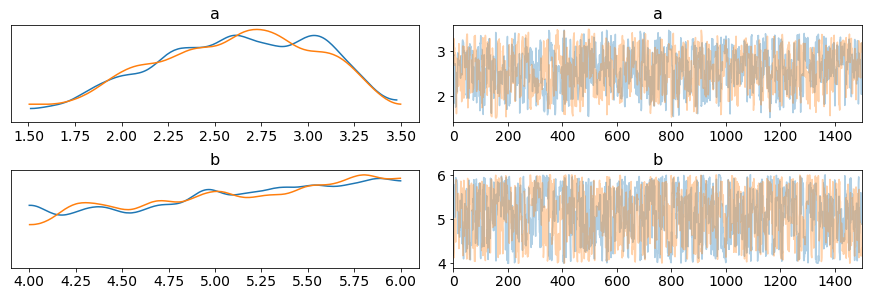

In [39]:
pm.traceplot(trace);